In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1),  # scale to [-1, 1]
])

dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [14]:
T = 1000
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_sample(x0, t, noise):
    ab = alpha_bar[t].view(-1, 1, 1, 1).to(x0.device)
    return torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * noise


In [15]:
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(-np.log(10000) * torch.arange(half) / (half - 1)).to(timesteps.device)
    angles = timesteps[:, None] * freqs[None]
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)
    return emb


In [16]:
class DiffusionModel(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, 256),
            nn.ReLU(),
        )
        self.conv1 = nn.Conv2d(2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)

        self.fc_time = nn.Linear(256, 28 * 28)

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, 128)
        t_emb = self.time_mlp(t_emb)
        t_img = self.fc_time(t_emb).view(-1, 1, 28, 28)
        x = torch.cat([x, t_img], dim=1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

def q_sample(x0, t, noise):
    ab = alpha_bar.to(x0.device)[t]  # move to correct device
    sqrt_ab = torch.sqrt(ab)[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - ab)[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise
    
for epoch in range(100):
    for x0, _ in tqdm(loader):
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise)
        pred = model(xt, t)

        loss = F.mse_loss(pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


100%|██████████| 469/469 [00:06<00:00, 68.22it/s]


Epoch 1 | Loss: 0.0856


100%|██████████| 469/469 [00:07<00:00, 65.21it/s]


Epoch 2 | Loss: 0.0678


100%|██████████| 469/469 [00:07<00:00, 66.19it/s]


Epoch 3 | Loss: 0.0482


100%|██████████| 469/469 [00:06<00:00, 67.96it/s]


Epoch 4 | Loss: 0.0584


100%|██████████| 469/469 [00:06<00:00, 67.04it/s]


Epoch 5 | Loss: 0.0431


100%|██████████| 469/469 [00:06<00:00, 68.05it/s]


Epoch 6 | Loss: 0.0383


100%|██████████| 469/469 [00:07<00:00, 66.95it/s]


Epoch 7 | Loss: 0.0547


100%|██████████| 469/469 [00:06<00:00, 67.97it/s]


Epoch 8 | Loss: 0.0523


100%|██████████| 469/469 [00:06<00:00, 68.05it/s]


Epoch 9 | Loss: 0.0442


100%|██████████| 469/469 [00:06<00:00, 67.15it/s]


Epoch 10 | Loss: 0.0462


100%|██████████| 469/469 [00:06<00:00, 68.89it/s]


Epoch 11 | Loss: 0.0390


100%|██████████| 469/469 [00:07<00:00, 66.13it/s]


Epoch 12 | Loss: 0.0511


100%|██████████| 469/469 [00:06<00:00, 67.11it/s]


Epoch 13 | Loss: 0.0346


100%|██████████| 469/469 [00:06<00:00, 68.00it/s]


Epoch 14 | Loss: 0.0580


100%|██████████| 469/469 [00:07<00:00, 66.18it/s]


Epoch 15 | Loss: 0.0371


100%|██████████| 469/469 [00:06<00:00, 67.08it/s]


Epoch 16 | Loss: 0.0301


100%|██████████| 469/469 [00:07<00:00, 66.05it/s]


Epoch 17 | Loss: 0.0362


100%|██████████| 469/469 [00:06<00:00, 67.09it/s]


Epoch 18 | Loss: 0.0374


100%|██████████| 469/469 [00:06<00:00, 67.95it/s]


Epoch 19 | Loss: 0.0322


100%|██████████| 469/469 [00:06<00:00, 67.07it/s]


Epoch 20 | Loss: 0.0384


100%|██████████| 469/469 [00:06<00:00, 68.09it/s]


Epoch 21 | Loss: 0.0357


100%|██████████| 469/469 [00:06<00:00, 67.07it/s]


Epoch 22 | Loss: 0.0296


100%|██████████| 469/469 [00:06<00:00, 67.06it/s]


Epoch 23 | Loss: 0.0310


100%|██████████| 469/469 [00:06<00:00, 67.07it/s]


Epoch 24 | Loss: 0.0353


100%|██████████| 469/469 [00:06<00:00, 67.03it/s]


Epoch 25 | Loss: 0.0434


100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


Epoch 26 | Loss: 0.0366


100%|██████████| 469/469 [00:06<00:00, 67.03it/s]


Epoch 27 | Loss: 0.0326


100%|██████████| 469/469 [00:06<00:00, 67.95it/s]


Epoch 28 | Loss: 0.0313


100%|██████████| 469/469 [00:06<00:00, 67.99it/s]


Epoch 29 | Loss: 0.0313


100%|██████████| 469/469 [00:06<00:00, 68.90it/s]


Epoch 30 | Loss: 0.0331


100%|██████████| 469/469 [00:06<00:00, 67.15it/s]


Epoch 31 | Loss: 0.0323


100%|██████████| 469/469 [00:06<00:00, 67.80it/s]


Epoch 32 | Loss: 0.0388


100%|██████████| 469/469 [00:06<00:00, 67.11it/s]


Epoch 33 | Loss: 0.0418


100%|██████████| 469/469 [00:06<00:00, 67.96it/s]


Epoch 34 | Loss: 0.0331


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 35 | Loss: 0.0317


100%|██████████| 469/469 [00:06<00:00, 67.95it/s]


Epoch 36 | Loss: 0.0418


100%|██████████| 469/469 [00:06<00:00, 68.09it/s]


Epoch 37 | Loss: 0.0244


100%|██████████| 469/469 [00:06<00:00, 68.03it/s]


Epoch 38 | Loss: 0.0314


100%|██████████| 469/469 [00:06<00:00, 67.12it/s]


Epoch 39 | Loss: 0.0335


100%|██████████| 469/469 [00:06<00:00, 68.02it/s]


Epoch 40 | Loss: 0.0335


100%|██████████| 469/469 [00:06<00:00, 67.09it/s]


Epoch 41 | Loss: 0.0359


100%|██████████| 469/469 [00:06<00:00, 67.06it/s]


Epoch 42 | Loss: 0.0306


100%|██████████| 469/469 [00:06<00:00, 68.04it/s]


Epoch 43 | Loss: 0.0329


100%|██████████| 469/469 [00:07<00:00, 66.88it/s]


Epoch 44 | Loss: 0.0339


100%|██████████| 469/469 [00:06<00:00, 67.97it/s]


Epoch 45 | Loss: 0.0255


100%|██████████| 469/469 [00:06<00:00, 67.92it/s]


Epoch 46 | Loss: 0.0318


100%|██████████| 469/469 [00:06<00:00, 68.06it/s]


Epoch 47 | Loss: 0.0345


100%|██████████| 469/469 [00:06<00:00, 68.05it/s]


Epoch 48 | Loss: 0.0326


100%|██████████| 469/469 [00:06<00:00, 67.16it/s]


Epoch 49 | Loss: 0.0409


100%|██████████| 469/469 [00:06<00:00, 67.03it/s]


Epoch 50 | Loss: 0.0289


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 51 | Loss: 0.0362


100%|██████████| 469/469 [00:06<00:00, 67.15it/s]


Epoch 52 | Loss: 0.0233


100%|██████████| 469/469 [00:06<00:00, 67.00it/s]


Epoch 53 | Loss: 0.0417


100%|██████████| 469/469 [00:06<00:00, 67.13it/s]


Epoch 54 | Loss: 0.0366


100%|██████████| 469/469 [00:07<00:00, 66.01it/s]


Epoch 55 | Loss: 0.0303


100%|██████████| 469/469 [00:06<00:00, 67.07it/s]


Epoch 56 | Loss: 0.0329


100%|██████████| 469/469 [00:06<00:00, 68.13it/s]


Epoch 57 | Loss: 0.0283


100%|██████████| 469/469 [00:06<00:00, 68.06it/s]


Epoch 58 | Loss: 0.0299


100%|██████████| 469/469 [00:06<00:00, 68.01it/s]


Epoch 59 | Loss: 0.0280


100%|██████████| 469/469 [00:06<00:00, 68.93it/s]


Epoch 60 | Loss: 0.0280


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 61 | Loss: 0.0293


100%|██████████| 469/469 [00:06<00:00, 67.94it/s]


Epoch 62 | Loss: 0.0375


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 63 | Loss: 0.0364


100%|██████████| 469/469 [00:06<00:00, 68.04it/s]


Epoch 64 | Loss: 0.0262


100%|██████████| 469/469 [00:06<00:00, 68.06it/s]


Epoch 65 | Loss: 0.0334


100%|██████████| 469/469 [00:06<00:00, 68.09it/s]


Epoch 66 | Loss: 0.0308


100%|██████████| 469/469 [00:06<00:00, 67.85it/s]


Epoch 67 | Loss: 0.0335


100%|██████████| 469/469 [00:06<00:00, 67.09it/s]


Epoch 68 | Loss: 0.0381


100%|██████████| 469/469 [00:06<00:00, 67.13it/s]


Epoch 69 | Loss: 0.0330


100%|██████████| 469/469 [00:06<00:00, 67.93it/s]


Epoch 70 | Loss: 0.0281


100%|██████████| 469/469 [00:06<00:00, 67.08it/s]


Epoch 71 | Loss: 0.0276


100%|██████████| 469/469 [00:06<00:00, 69.05it/s]


Epoch 72 | Loss: 0.0354


100%|██████████| 469/469 [00:06<00:00, 68.03it/s]


Epoch 73 | Loss: 0.0273


100%|██████████| 469/469 [00:06<00:00, 68.99it/s]


Epoch 74 | Loss: 0.0230


100%|██████████| 469/469 [00:06<00:00, 67.18it/s]


Epoch 75 | Loss: 0.0266


100%|██████████| 469/469 [00:06<00:00, 67.93it/s]


Epoch 76 | Loss: 0.0310


100%|██████████| 469/469 [00:06<00:00, 67.07it/s]


Epoch 77 | Loss: 0.0269


100%|██████████| 469/469 [00:06<00:00, 68.02it/s]


Epoch 78 | Loss: 0.0318


100%|██████████| 469/469 [00:06<00:00, 67.16it/s]


Epoch 79 | Loss: 0.0299


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 80 | Loss: 0.0328


100%|██████████| 469/469 [00:06<00:00, 68.04it/s]


Epoch 81 | Loss: 0.0280


100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch 82 | Loss: 0.0372


100%|██████████| 469/469 [00:06<00:00, 67.99it/s]


Epoch 83 | Loss: 0.0310


100%|██████████| 469/469 [00:06<00:00, 67.08it/s]


Epoch 84 | Loss: 0.0278


100%|██████████| 469/469 [00:06<00:00, 68.08it/s]


Epoch 85 | Loss: 0.0248


100%|██████████| 469/469 [00:06<00:00, 68.02it/s]


Epoch 86 | Loss: 0.0344


100%|██████████| 469/469 [00:06<00:00, 68.95it/s]


Epoch 87 | Loss: 0.0294


100%|██████████| 469/469 [00:06<00:00, 67.11it/s]


Epoch 88 | Loss: 0.0285


100%|██████████| 469/469 [00:06<00:00, 67.11it/s]


Epoch 89 | Loss: 0.0332


100%|██████████| 469/469 [00:06<00:00, 67.99it/s]


Epoch 90 | Loss: 0.0321


100%|██████████| 469/469 [00:06<00:00, 68.02it/s]


Epoch 91 | Loss: 0.0327


100%|██████████| 469/469 [00:06<00:00, 67.09it/s]


Epoch 92 | Loss: 0.0428


100%|██████████| 469/469 [00:07<00:00, 66.99it/s]


Epoch 93 | Loss: 0.0282


100%|██████████| 469/469 [00:06<00:00, 68.08it/s]


Epoch 94 | Loss: 0.0285


100%|██████████| 469/469 [00:06<00:00, 68.95it/s]


Epoch 95 | Loss: 0.0285


100%|██████████| 469/469 [00:06<00:00, 68.12it/s]


Epoch 96 | Loss: 0.0293


100%|██████████| 469/469 [00:06<00:00, 68.92it/s]


Epoch 97 | Loss: 0.0255


100%|██████████| 469/469 [00:06<00:00, 69.01it/s]


Epoch 98 | Loss: 0.0292


100%|██████████| 469/469 [00:06<00:00, 68.97it/s]


Epoch 99 | Loss: 0.0321


100%|██████████| 469/469 [00:06<00:00, 67.96it/s]

Epoch 100 | Loss: 0.0307


In [18]:
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    for t_ in reversed(range(T)):
        t = torch.full((n,), t_, device=device)
        z = torch.randn_like(x) if t_ > 0 else 0
        pred_noise = model(x, t)
        a = alpha[t_].to(x.device)
        ab = alpha_bar[t_].to(x.device)
        x = (1 / torch.sqrt(a)) * (x - ((1 - a) / torch.sqrt(1 - ab)) * pred_noise) + beta[t_].sqrt().to(x.device) * z
    return x


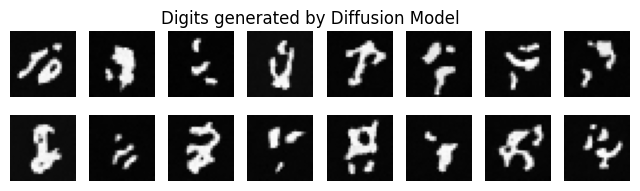

In [19]:
images = sample(model, n=16).cpu()

plt.figure(figsize=(8, 2))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Digits generated by Diffusion Model")
plt.show()
